## Preprocess

**Import train and test datasets**

In [200]:
import pandas as pd
from lightgbm import LGBMClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

train_data = pd.read_csv("input_data/train.csv")
test_data = pd.read_csv("input_data/test.csv")

train_data['date'] = pd.to_datetime(train_data['date'], format='%Y-%m-%d')
test_data['date'] = pd.to_datetime(test_data['date'], format='%Y-%m-%d')

In [176]:
weekday = [
        time.strptime(datetime(
                date.date().year,
                date.date().month,
                date.date().day
            ).strftime("%A"), "%A").tm_wday
            for date in train_data["date"].copy()
        ]

train_data["weekday"] = weekday

In [14]:
def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

In [220]:
train_data.info()
print(train_data.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
id          230130
date        230130
country     230130
store       230130
product     230130
num_sold    221259
dtype: int64


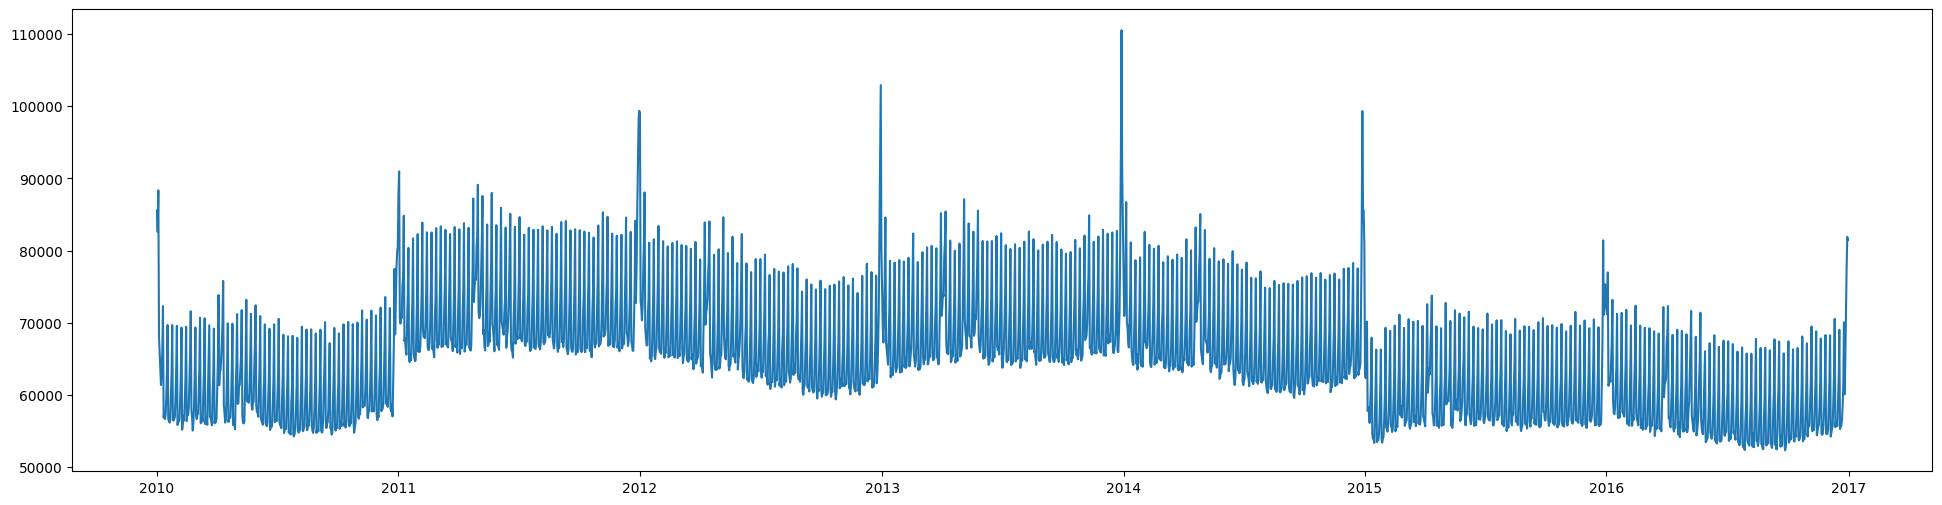

In [96]:
plt.figure(figsize=(24,6))
plt.plot(train_data.groupby('date')['num_sold'].sum())
plt.show()

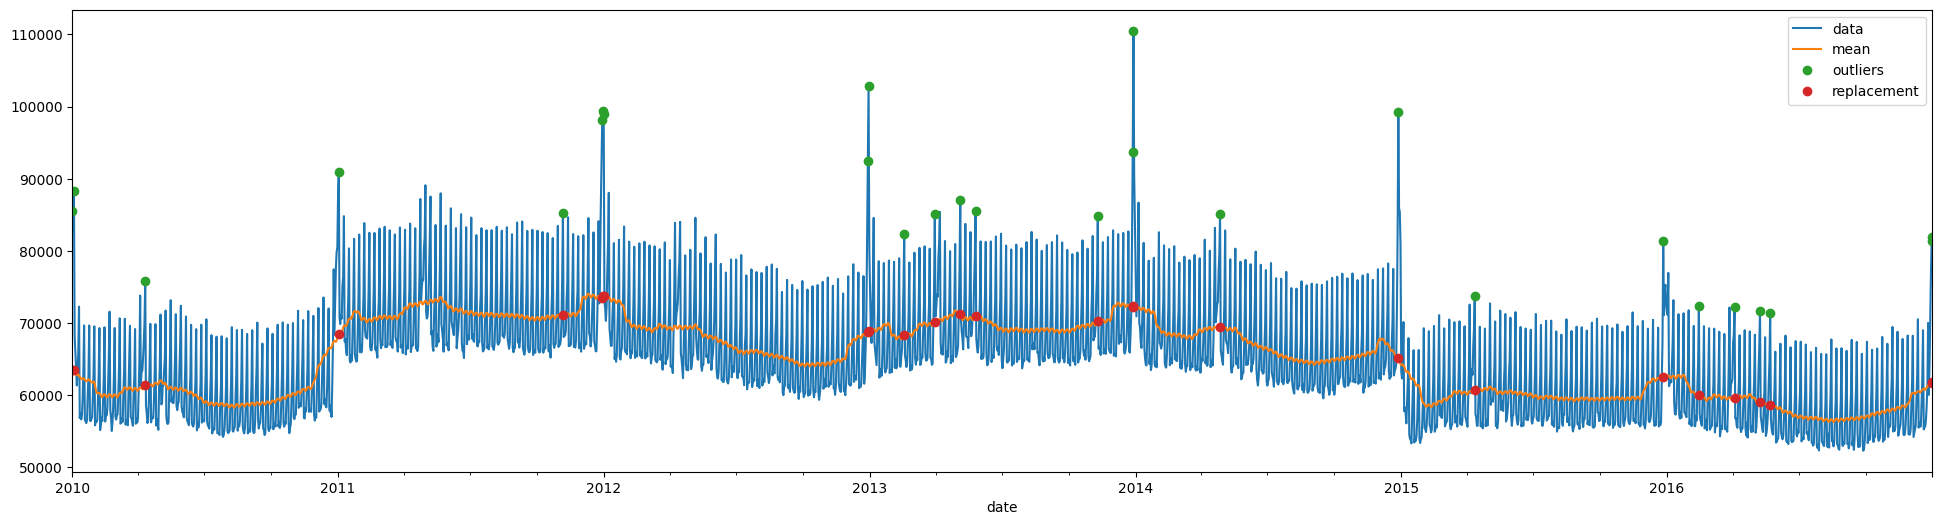

In [146]:
# n_sold_per_day = train_data.groupby('date')['num_sold'].sum()
# z, avg, std, m = zscore(n_sold_per_day, window=10, return_all=True, thresh=1000)

# ax = plt.figure()

# n_sold_per_day.plot(label='num_sold')
# avg.plot(label='mean')
# n_sold_per_day.loc[~m, 'date'].plot(label='outliers', marker='o', ls='')


# #avg[~m].plot(label='replacement', marker='o', ls='')
# plt.legend()

plt.figure(figsize=(24,6))
n_sold_per_day = train_data.groupby('date')['num_sold'].sum()
z, avg, std, m = zscore(n_sold_per_day, window=60, return_all=True, thresh=2.4)

ax = plt.subplot()

n_sold_per_day.plot(label='data')
avg.plot(label='mean')

# Plot outliers and replacement points
n_sold_per_day.loc[~m].plot(label='outliers', marker='o', ls='')
avg[~m].plot(label='replacement', marker='o', ls='')

plt.legend()
plt.show()


In [133]:
m[~m]

date
2010-01-03    False
2011-01-02    False
2011-12-30    False
2011-12-31    False
2012-01-01    False
2012-12-29    False
2012-12-30    False
2013-12-29    False
2014-12-28    False
2015-12-27    False
Name: num_sold, dtype: bool

In [147]:
m.value_counts()

print("Length of n_sold_per_day:", len(n_sold_per_day))
print("Length of m:", len(m))
print("Number of True in ~m:", (~m).sum())


Length of n_sold_per_day: 2557
Length of m: 2557
Number of True in ~m: 27


<Figure size 2400x600 with 0 Axes>

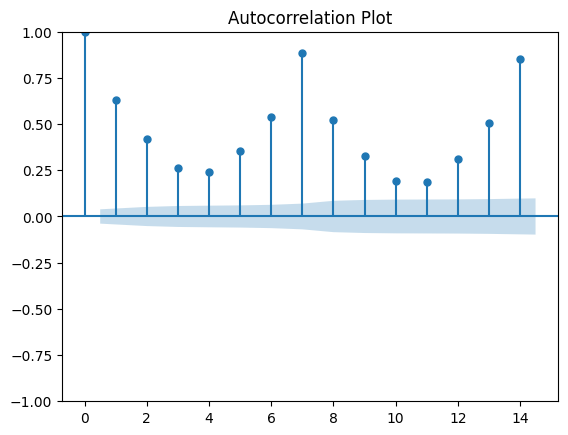

In [194]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(24, 6))
plot_acf(train_data.groupby('date')['num_sold'].sum().dropna(), lags=14)
plt.title('Autocorrelation Plot')
plt.show()

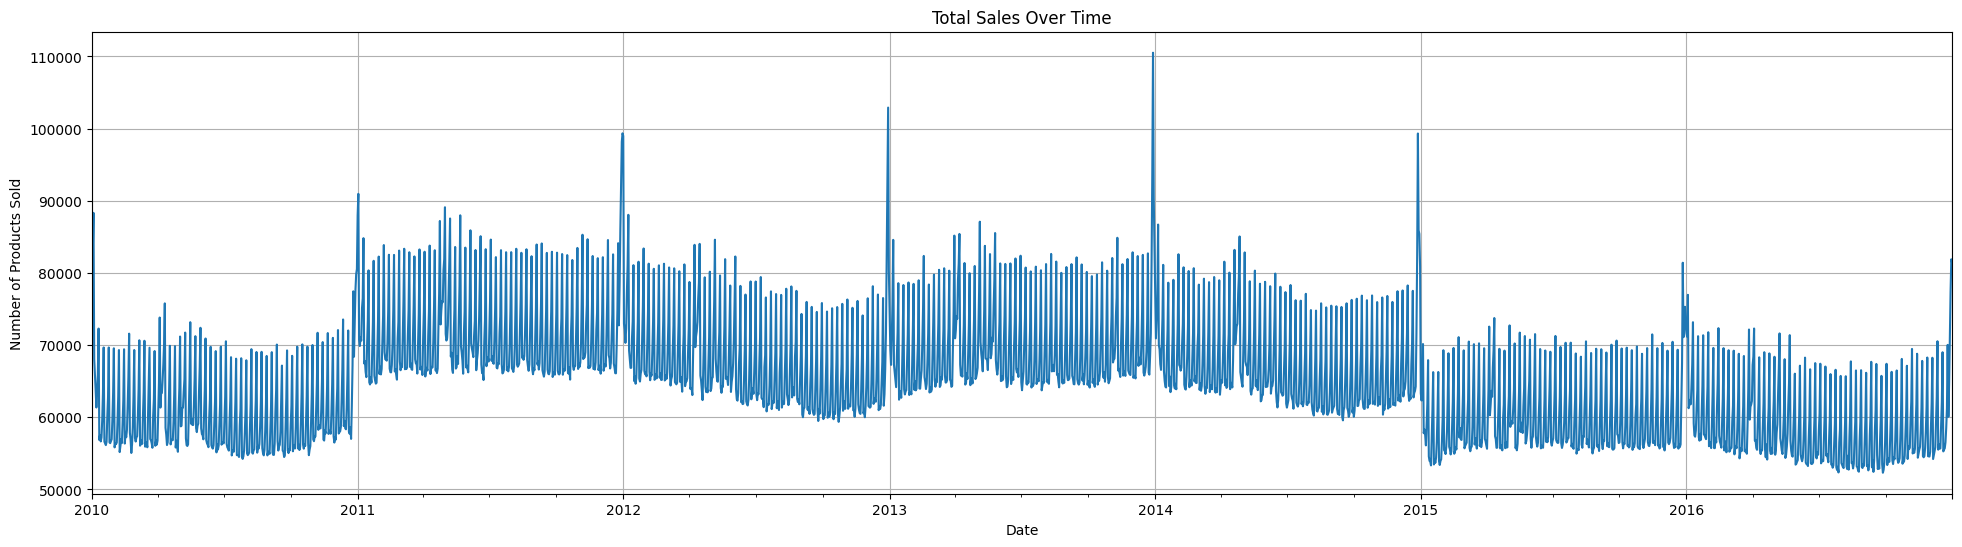

In [49]:
plt.figure(figsize=(24,6))
train_data.groupby('date')['num_sold'].sum().plot(xlabel='Date', 
                                             ylabel='Number of Products Sold', 
                                             title='Total Sales Over Time')
plt.grid()
plt.show()

**Process data for training and testing**

In [197]:
def get_processed_data(data:pd.DataFrame):
    from datetime import datetime
    import time

    data = data.copy()
    
    weekday = [
        time.strptime(datetime(
                date.date().year,
                date.date().month,
                date.date().day
            ).strftime("%A"), "%A").tm_wday
            for date in data["date"].copy()
        ]
    year = [
            date.date().year
            for date in data["date"].copy()
    ]


    days_of_the_year = np.array([int(datetime(date.date().year, date.date().month, date.date().day).timetuple().tm_yday) for date in data["date"].copy()])
    # sin/cos of year interval
    data["year_sin"] = np.sin(2 * np.pi * days_of_the_year / 365.25)
    data["year_cos"] = np.cos(2 * np.pi * days_of_the_year / 365.25)
    # sin/cos of two year interval
    data["year_sin2"] = np.sin(2 * np.pi * (days_of_the_year + (365.25 * (np.array(year) % 2))) / (2 * 365.25))
    data["year_cos2"] = np.cos(2 * np.pi * (days_of_the_year + (365.25 * (np.array(year) % 2))) / (2 * 365.25))
    # sin/cos of weekday
    data["weekday_sin"] = np.sin(2 * np.pi * np.array(weekday) / 7)
    data["weekday_cos"] = np.cos(2 * np.pi * np.array(weekday) / 7)

    data = data.drop('date', axis=1)

    data["weekday"] = weekday
    data["year"] = year

    if "num_sold" not in data.keys():
        data["num_sold"] = [0 for i in data["id"]]

    data = data.drop('id', axis=1)

    data["num_sold"] = data["num_sold"].fillna(0)
    train_df = data.dropna().reset_index(drop=True)
    X, y = train_df.drop('num_sold',axis=1), train_df.num_sold

    for feat in X.select_dtypes(exclude='O').columns:
        X[feat].fillna(X[feat].median())
        X[feat+'_bin'] = pd.qcut(X[feat],q=20,duplicates='drop',labels=False)
    cat_feat = X.select_dtypes(include='O').columns.tolist()
    X[cat_feat] = X[cat_feat].fillna('NA')
    X = pd.get_dummies(X,columns=cat_feat,drop_first=True,dtype=int)

    return (X, y)

train_X, train_y = get_processed_data(train_data)

test_X, _ = get_processed_data(test_data)

list(train_X.columns)

['weekday',
 'year_sin',
 'year_cos',
 'year_sin2',
 'year_cos2',
 'weekday_sin',
 'weekday_cos',
 'year',
 'weekday_bin',
 'year_sin_bin',
 'year_cos_bin',
 'year_sin2_bin',
 'year_cos2_bin',
 'weekday_sin_bin',
 'weekday_cos_bin',
 'year_bin',
 'country_Finland',
 'country_Italy',
 'country_Kenya',
 'country_Norway',
 'country_Singapore',
 'store_Premium Sticker Mart',
 'store_Stickers for Less',
 'product_Kaggle',
 'product_Kaggle Tiers',
 'product_Kerneler',
 'product_Kerneler Dark Mode']

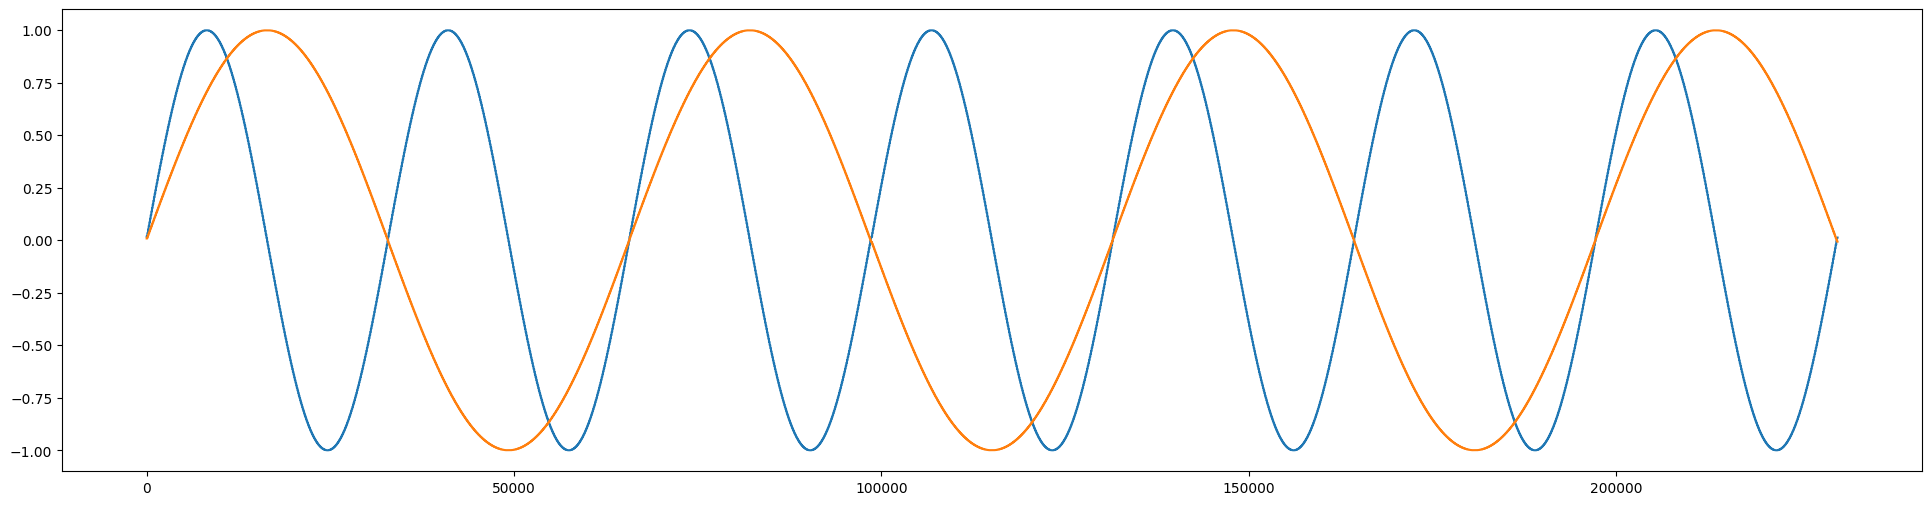

In [193]:
plt.figure(figsize=(24,6))
plt.plot(train_X['year_sine'])
plt.plot(train_X['year_sine2'])
plt.show()

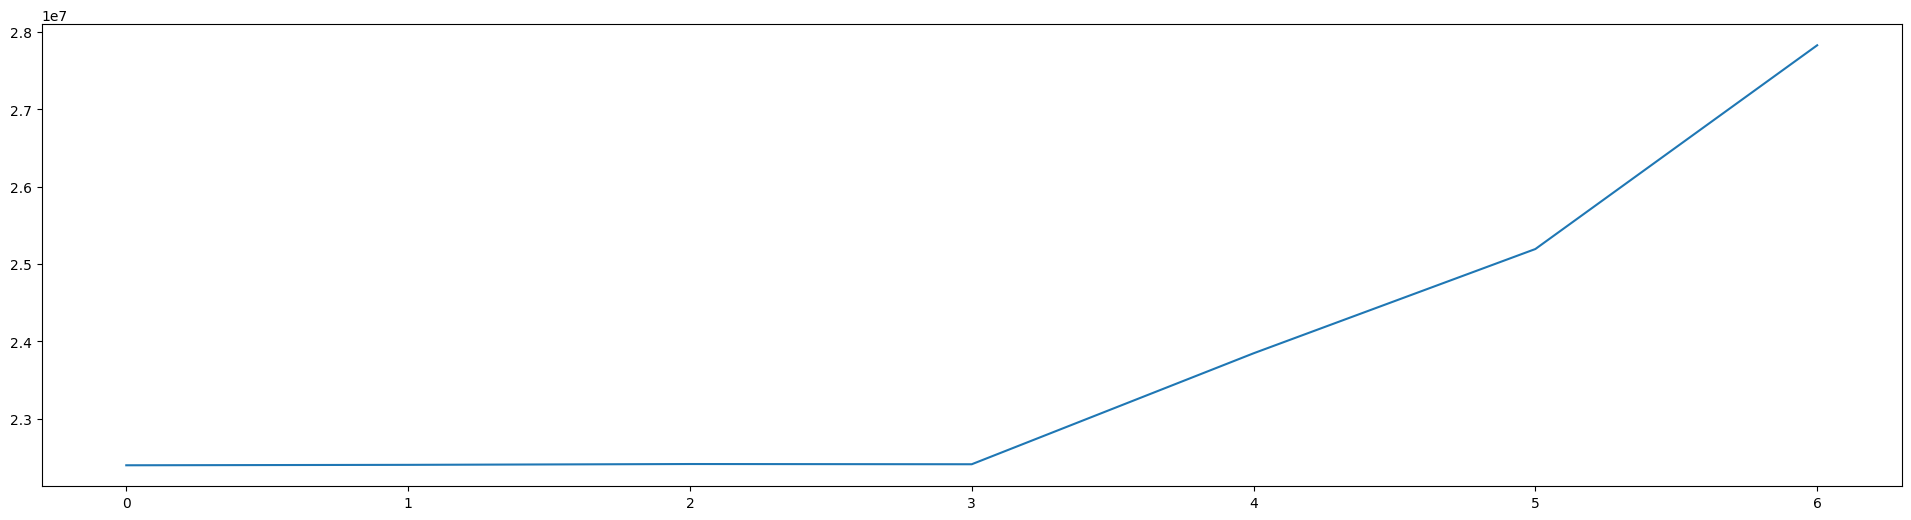

In [178]:
plt.figure(figsize=(24,6))
plt.plot(train_data.groupby('weekday')['num_sold'].sum())
plt.show()

In [263]:
print(train_y)

0            0.0
1          973.0
2          906.0
3          423.0
4          491.0
           ...  
230125     466.0
230126    2907.0
230127    2299.0
230128    1242.0
230129    1622.0
Name: num_sold, Length: 230130, dtype: float64


**Create model**

In [264]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(max_depth=10, n_estimators=1000, learning_rate=0.01, reg_alpha=1, reg_lambda=1, scale_pos_weight=3.5, verbose=-1, objective="regression")

**Train model**

In [265]:
import numpy as np

def mean_cross_validation_scores(score):
    mean_scores = {metric: np.mean(values) for metric, values in score.items()}
    return pd.DataFrame(mean_scores, index=['Score'])

In [266]:
from sklearn.model_selection import cross_validate

#score = cross_validate(model, train_X, train_y, cv=5, scoring=['roc_auc'])
score = cross_validate(model, train_X, train_y, cv=5, scoring=['neg_mean_squared_error', 'r2'])


In [267]:
mean_cross_validation_scores(score)

,fit_time,score_time,test_neg_mean_squared_error,test_r2
Score,2.03632,0.337169,-19559.11122,0.958341


In [268]:
model.fit(train_X,train_y)

LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
              objective='regression', reg_alpha=1, reg_lambda=1,
              scale_pos_weight=3.5, verbose=-1)

In [269]:
# train_X['pred_prob'] = model.predict_proba(train_X)[:,1]
# test_X['pred_prob'] = model.predict_proba(test_X)[:,1]

In [270]:
# pred = model.predict_proba(test_X)[:,1]

train_X['raw_score'] = model.predict(train_X, raw_score=True)

# Convert raw scores to probabilities
train_X['pred_prob'] = 1 / (1 + np.exp(-train_X['raw_score']))

# Repeat for the test set
test_X['raw_score'] = model.predict(test_X, raw_score=True)
test_X['pred_prob'] = 1 / (1 + np.exp(-test_X['raw_score']))

In [271]:
test_X['raw_score']
test_X['pred_prob']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
98545    1.0
98546    1.0
98547    1.0
98548    1.0
98549    1.0
Name: pred_prob, Length: 98550, dtype: float64

In [272]:
submission = pd.DataFrame({"id": test_data['id'], "num_sold": test_X['raw_score']})
submission.to_csv("submission.csv", index=False)

In [203]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings("ignore")

# Constants
RANDOM_SEED = 42

# Load data
train_data = pd.read_csv("input_data/train.csv")
test_data = pd.read_csv("input_data/test.csv")

# Drop rows where 'num_sold' is missing in training data
train_data = train_data.dropna(subset=['num_sold']).reset_index(drop=True)

# Separate features and target
X = train_data.drop(columns=['num_sold', 'id'])
y = train_data['num_sold']
X_test = test_data.drop(columns=['id'])

# Minimal preprocessing: Handle categorical variables with one-hot encoding
def preprocess_data(df):
    df = pd.get_dummies(df, drop_first=True)
    return df

X = preprocess_data(X)
X_test = preprocess_data(X_test)

# Align columns between train and test sets
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Hyperparameter optimization
fast_training = {
    "stopping_rounds": 10,
    "n_trials": 10,
}
medium_training = {
    "stopping_rounds": 20,
    "n_trials": 30,
}
final_training = {
    "stopping_rounds": 20,
    "n_trials": 1000,
}

# Mode for training
training_mode = fast_training

def objective(trial):
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.9),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "objective": "regression",
        "metric": "mape",
        "boosting_type": "gbdt",
        "random_state": RANDOM_SEED,
        "n_jobs": -1,
        "verbose": -1,
    }

    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    mape_scores = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = lgb.LGBMRegressor(**param, n_estimators=1000, device='gpu')
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="mape",
            callbacks=[lgb.early_stopping(stopping_rounds=training_mode["stopping_rounds"])] # increase for heavier training
        )

        preds = model.predict(X_valid)
        mape_scores.append(mean_absolute_percentage_error(y_valid, preds))

    return np.mean(mape_scores)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=training_mode["n_trials"])  # Reduced number of trials for faster execution

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    "objective": "regression",
    "metric": "mape",
    "boosting_type": "gbdt",
    "random_state": RANDOM_SEED,
    "n_estimators": 1000,  # Increase for final training
})

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X, y)

# Predict on test data
y_pred = final_model.predict(X_test)

# Save predictions
submission = pd.DataFrame({"id": test_data['id'], "num_sold": y_pred})
submission.to_csv("submission.csv", index=False)

print("Submission file created.")


[I 2025-01-23 20:12:33,391] A new study created in memory with name: no-name-989b8e6d-720c-4eb3-a044-9f18426bee4a


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's mape: 0.470092
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's mape: 0.518071
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's mape: 0.4565


[I 2025-01-23 20:13:12,236] Trial 0 finished with value: 0.48155454457856955 and parameters: {'learning_rate': 0.12101572424517588, 'num_leaves': 39, 'max_depth': 8, 'feature_fraction': 0.6174386962582677, 'bagging_fraction': 0.7071696586063022, 'bagging_freq': 1, 'lambda_l1': 3.00086919293737, 'lambda_l2': 4.367478387164007}. Best is trial 0 with value: 0.48155454457856955.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's mape: 0.441089
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's mape: 0.441999
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's mape: 0.434569


[I 2025-01-23 20:13:49,675] Trial 1 finished with value: 0.43921906013926887 and parameters: {'learning_rate': 0.05332298140136584, 'num_leaves': 24, 'max_depth': 8, 'feature_fraction': 0.7430910439195902, 'bagging_fraction': 0.626143080973407, 'bagging_freq': 4, 'lambda_l1': 3.1420467982336984, 'lambda_l2': 4.976263065852481}. Best is trial 1 with value: 0.43921906013926887.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	valid_0's mape: 0.237248
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's mape: 0.23842
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	valid_0's mape: 0.240101


[I 2025-01-23 20:14:25,764] Trial 2 finished with value: 0.238590020353485 and parameters: {'learning_rate': 0.10300139952369816, 'num_leaves': 26, 'max_depth': 8, 'feature_fraction': 0.8666870075575015, 'bagging_fraction': 0.6951868675385122, 'bagging_freq': 5, 'lambda_l1': 4.635345871510823, 'lambda_l2': 4.27398579203439}. Best is trial 2 with value: 0.238590020353485.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[92]	valid_0's mape: 0.544398
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's mape: 0.538462
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's mape: 0.540339


[I 2025-01-23 20:15:04,044] Trial 3 finished with value: 0.5410662333377565 and parameters: {'learning_rate': 0.05067527612405455, 'num_leaves': 48, 'max_depth': 5, 'feature_fraction': 0.741549893241546, 'bagging_fraction': 0.6912836676013306, 'bagging_freq': 3, 'lambda_l1': 2.357788249559712, 'lambda_l2': 2.6780098147996063}. Best is trial 2 with value: 0.238590020353485.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's mape: 0.291025
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's mape: 0.289107
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's mape: 0.268994


[I 2025-01-23 20:15:38,642] Trial 4 finished with value: 0.283042413492443 and parameters: {'learning_rate': 0.18755992389053666, 'num_leaves': 23, 'max_depth': 10, 'feature_fraction': 0.8162955109883101, 'bagging_fraction': 0.8710287526906932, 'bagging_freq': 1, 'lambda_l1': 3.2603803372941718, 'lambda_l2': 0.1839983599436662}. Best is trial 2 with value: 0.238590020353485.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's mape: 0.373643
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's mape: 0.363132
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's mape: 0.364353


[I 2025-01-23 20:16:15,122] Trial 5 finished with value: 0.36704296528698066 and parameters: {'learning_rate': 0.05942765806052387, 'num_leaves': 38, 'max_depth': 10, 'feature_fraction': 0.7217917413660491, 'bagging_fraction': 0.6464315317221905, 'bagging_freq': 1, 'lambda_l1': 3.661546072582067, 'lambda_l2': 3.60095746551669}. Best is trial 2 with value: 0.238590020353485.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's mape: 0.319857
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's mape: 0.318279
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's mape: 0.333347


[I 2025-01-23 20:16:50,774] Trial 6 finished with value: 0.32382770246808384 and parameters: {'learning_rate': 0.11738591867126434, 'num_leaves': 40, 'max_depth': 9, 'feature_fraction': 0.6994691568501635, 'bagging_fraction': 0.8949785216954519, 'bagging_freq': 1, 'lambda_l1': 0.6669381404071928, 'lambda_l2': 4.140233052787784}. Best is trial 2 with value: 0.238590020353485.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's mape: 0.474575
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's mape: 0.466659
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's mape: 0.467225


[I 2025-01-23 20:17:27,778] Trial 7 finished with value: 0.46948626981648856 and parameters: {'learning_rate': 0.12110116321028618, 'num_leaves': 46, 'max_depth': 5, 'feature_fraction': 0.7547441997707109, 'bagging_fraction': 0.8600428804971525, 'bagging_freq': 3, 'lambda_l1': 0.7254964198190261, 'lambda_l2': 2.9375374237206415}. Best is trial 2 with value: 0.238590020353485.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's mape: 0.293029
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's mape: 0.294247
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's mape: 0.293649


[I 2025-01-23 20:18:03,024] Trial 8 finished with value: 0.2936417025902039 and parameters: {'learning_rate': 0.11866332087098508, 'num_leaves': 42, 'max_depth': 7, 'feature_fraction': 0.7381162910979975, 'bagging_fraction': 0.8846578093750361, 'bagging_freq': 1, 'lambda_l1': 0.1295107936846024, 'lambda_l2': 2.3808475423106783}. Best is trial 2 with value: 0.238590020353485.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's mape: 0.389815
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's mape: 0.401211
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[92]	valid_0's mape: 0.3865


[I 2025-01-23 20:18:40,378] Trial 9 finished with value: 0.3925086308780898 and parameters: {'learning_rate': 0.05225005390491386, 'num_leaves': 43, 'max_depth': 5, 'feature_fraction': 0.8280088702223627, 'bagging_fraction': 0.6163521397439172, 'bagging_freq': 5, 'lambda_l1': 4.723090997057508, 'lambda_l2': 3.789726613688016}. Best is trial 2 with value: 0.238590020353485.


Submission file created.


In [204]:
best_params

{'learning_rate': 0.10300139952369816,
 'num_leaves': 26,
 'max_depth': 8,
 'feature_fraction': 0.8666870075575015,
 'bagging_fraction': 0.6951868675385122,
 'bagging_freq': 5,
 'lambda_l1': 4.635345871510823,
 'lambda_l2': 4.27398579203439,
 'objective': 'regression',
 'metric': 'mape',
 'boosting_type': 'gbdt',
 'random_state': 42,
 'n_estimators': 2000}

In [206]:
study.best_value

0.238590020353485